### Uber stock price prediction project 

The purpose of this project is predicting the price of Uber stock to check whether it is going to match
the expected rise in earnings, which is estimated at over 1700% over the next 5 years. 

For project purpose the following hypotheses have been created:
    
    H1: Uber Stock will continue to grow on annual basis
    H2: Uber Stock will surpass the 110$ per share level in the 5 year horizon.
    
The test will be conducted using the least squares method with following data:
    
Explained variable (Y) - Uber Stock Price

Explanatory variablex (X):
    -lagged Uber Stock Price
    -S&P 500 Index
    -FED Interest Rate
    
Data Sources:
    
Uber Stock Price : https://finance.yahoo.com/quote/UBER/history
S&P 500 Index : https://stooq.pl/q/d/?s=%5Espx&c=0&d1=20190510&d2=20240308
FED Interest Rate : https://tradingeconomics.com/united-states/interest-rate

Before model application, data should be inspected for autocorrelation, stationarity, heteroscedasticity (optional), and cointegration (optional).

For data examination following tests were chosen:

Autocorrelation - Durbin-Watson test
Stationarity - Advanced Dickey-Fuller test
(optional) Heteroscedasticity - Breusch Pagan test
(optional) Cointegration - Johansen test

### Packages import

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


os.chdir("/Users/sbbogdyn/Downloads")

### Data import

In [62]:
UBER = pd.read_csv('UBER.csv')
SP500 = pd.read_csv('SP500.csv')
FED = pd.read_excel('FED INT.xlsx')

In [40]:
UBER

,Date,UBER
0,2019-05-10,41.570000
1,2019-05-13,37.099998
2,2019-05-14,39.959999
3,2019-05-15,41.290001
4,2019-05-16,43.000000
...,...,...
1211,2024-03-04,81.300003
1212,2024-03-05,79.089996
1213,2024-03-06,78.639999
1214,2024-03-07,79.410004


In [35]:
SP500

,Date,SP500
0,2019-05-10,2881.40
1,2019-05-13,2811.87
2,2019-05-14,2834.41
3,2019-05-15,2850.96
4,2019-05-16,2876.32
...,...,...
1211,2024-03-04,5130.95
1212,2024-03-05,5078.65
1213,2024-03-06,5104.76
1214,2024-03-07,5157.36


In [33]:
FED

,Date,FED Rate
0,2019-05-10,0.025
1,2019-05-13,0.025
2,2019-05-14,0.025
3,2019-05-15,0.025
4,2019-05-16,0.025
...,...,...
1211,2024-03-04,0.055
1212,2024-03-05,0.055
1213,2024-03-06,0.055
1214,2024-03-07,0.055


### Data Merge

In [63]:
#As the data for SP500 is spelled in polish, we have to change to wanted column names so
#they will match the rest of data. We will be using the end of day value for uber stock and SP500 index,
#so we will also rename those columns.

SP500.rename(columns={'Data': 'Date'}, inplace=True)
SP500.rename(columns={'Zamkniecie': 'SP500'}, inplace=True)
UBER.rename(columns={'Close': 'UBER'}, inplace=True)
FED.rename(columns={'Rate': 'FED Rate'}, inplace=True)

#As the wanted columns are renamed, we can drop the unwanted columns from the dataframes.

SP500.drop(columns={'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen'}, inplace=True)
UBER.drop(columns={'Open', 'High', 'Low', 'Adj Close', 'Volume'}, inplace=True)

#As we get rid off unwanted data, then we can merge these dataframes into one

DATA = pd.merge(UBER, SP500, on='Date', how='left')
DATA = pd.merge(DATA, FED, on='Date', how='left')

columns_to_convert = ['SP500', 'UBER', 'FED Rate']
DATA[columns_to_convert] = DATA[columns_to_convert].astype(int)

In [64]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1216 non-null   object
 1   UBER      1216 non-null   int64 
 2   SP500     1216 non-null   int64 
 3   FED Rate  1216 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 38.1+ KB


### Data Testing

In [52]:
#Advanced Dickey Fuller test for stationarity of data

#Stationarity is an econometrics term, meaning that a time series has a mean and variance, that does not change
#over the given time period. Non-stationary data can cause anomalies when being used for forecast modelling.
#They ADF test has following hypotheses
#H0: There is a unit root present in the time series, and the data is non-stationary.
#H1: There is no unit root present in the time series, and the data is stationary

def adf_test(DATA):
    result = adfuller(DATA, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

for col in ['SP500', 'UBER', 'FED Rate']:
    print(f"ADF Test for '{col}':")
    adf_test(DATA[col])
    print('\n')

ADF Test for 'SP500':
ADF Statistic: -1.083989334296683
p-value: 0.7214143596595537
Critical Values:
   1%: -3.435783891669927
   5%: -2.863939534252909
   10%: -2.56804755322338


ADF Test for 'UBER':
ADF Statistic: -0.3448485005849377
p-value: 0.9189078863806053
Critical Values:
   1%: -3.435743555099632
   5%: -2.8639217381867486
   10%: -2.568038075665972


ADF Test for 'FED Rate':
ADF Statistic: 0.7322261590625156
p-value: 0.9904595359556971
Critical Values:
   1%: -3.435743555099632
   5%: -2.8639217381867486
   10%: -2.568038075665972




In [ ]:
#The results of ADF test indicate that each of the variables showcases signs of non-stationarity,
#as high p-value indicates that there are no reasons to choose the alternative hypothesis.

Durbin-Watson Statistic for 'SP500': 0.00014216909095353608
Durbin-Watson Statistic for 'UBER': 0.0009056534281335155
Durbin-Watson Statistic for 'FED Rate': 0.0004716097006487657


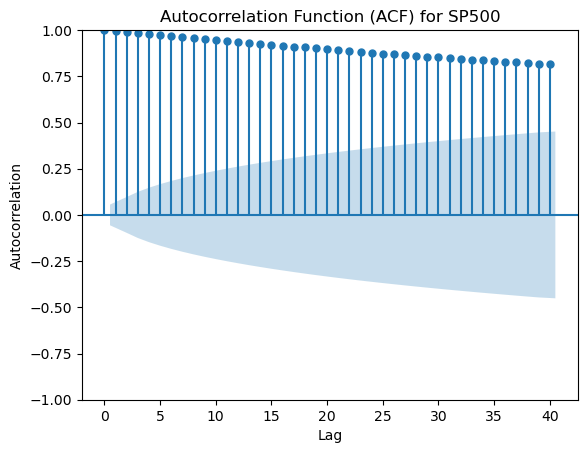

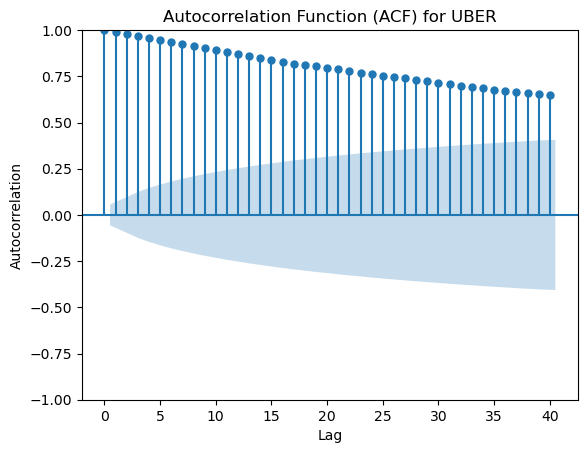

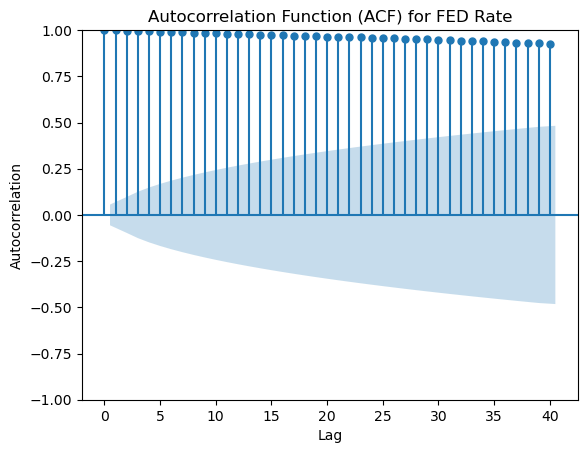

In [56]:
#Durbin Watson test for autocorrelation

#Autocorrelation assesses whether previous values of a time series are correlated with current or future values.

def durbin_watson_test(series, column):
    durbin_watson_statistic = sm.stats.stattools.durbin_watson(series)
    print(f"Durbin-Watson Statistic for '{column}': {durbin_watson_statistic}")


for col in ['SP500', 'UBER', 'FED Rate']:
    durbin_watson_test(DATA[col], col)

    
#Plotting autocorrelation function (ACF)    
    
def plot_acf(series, column):
    sm.graphics.tsa.plot_acf(series, lags=40)
    plt.title(f'Autocorrelation Function (ACF) for {column}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

# Perform ACF for each column
for col in ['SP500', 'UBER', 'FED Rate']:
    plot_acf(DATA[col], col)

In [ ]:
#The Durbin Watson test, as well as the charts showcase a strong positive autocorrelation for each of the variables.

In [70]:
#Breusch Pagan test for Heteroscedasticity

#Heteroscedascity showcases whether spread of the residuals varies as a function of one or more 
#independent variables in the regression model. The test hypotheses are:
#H0: The variance of the residuals is constant (homoscedasticity).
#H1: The variance of the residuals is not constant (heteroscedasticity).

y = DATA['UBER']
X = DATA[['SP500', 'FED Rate']]  

X = sm.add_constant(X)

# Perform the Breusch-Pagan test
lm = sm.OLS(y, X).fit()
_, pval, _, _ = het_breuschpagan(lm.resid, X)
print("Breusch-Pagan Test p-value:", pval)

Breusch-Pagan Test p-value: 1.8688929231452551e-22


In [ ]:
#As the p-value of Breusch-Pagan Test is less than 0.05, we can reject the null hypothesis, and by that assume 
#that there is heterescedasticity occuring.

In [71]:
#Johansen test for cointegration (optional)
#
#When dealing with non stationary data, we can perform an optional test for variable cointegration, which can
#determine whether a linear combination of two or more non-stationary variables can be stationary

#def johansen_cointegration_test(data):
#    result = coint_johansen(data, det_order=0, k_ar_diff=1)
#
#    print("Eigenvalues:")
#    print(result.eig)
#
#    print("\nTrace Statistics:")
#    print("Trace statistic: ", result.lr1)
#    print("Critical values (90%, 95%, 99%): ", result.cvt)
#
#    print("\nMaximum Eigenvalue Statistics:")
#    print("Max eigenvalue statistic: ", result.lr2)
#    print("Critical values (90%, 95%, 99%): ", result.cvm)

### Model creation

Mean Squared Error (MSE) on test set: 1.761926555423249


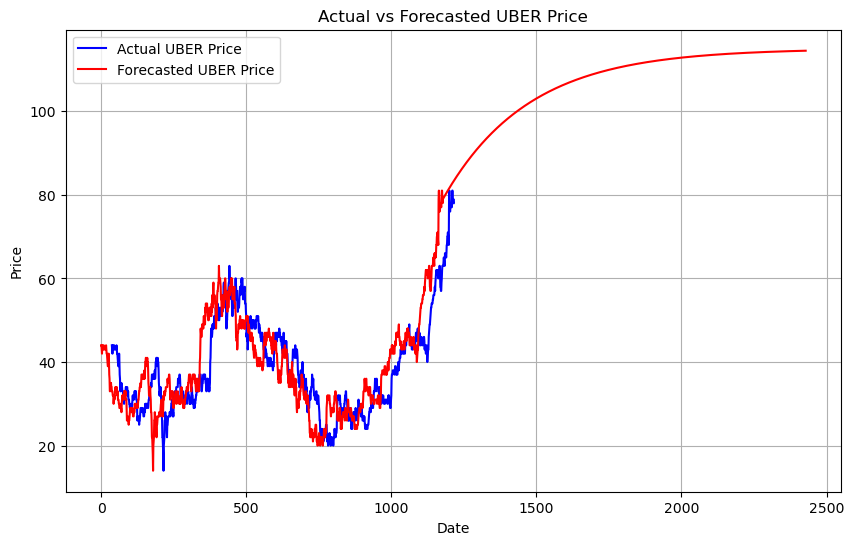

In [113]:
#Our model will consist of UBER Stock price as explained variable (Y) and 3 explaing variables (X):
#SP500 index, FED interest rate and lagged UBER Stock price from previous month.

DATA['UBER_lagged'] = DATA['UBER'].shift(1)

DATA = DATA.dropna()

# Splitting the data into training and testing sets
X = DATA[['UBER_lagged', 'SP500', 'FED Rate']]
y = DATA['UBER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Creating and training the model
model = LinearRegression()
model.fit(X_train, y_train)


predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error (MSE) on test set:', mse)

# Making predictions for the next 5 years
forecast_days = 5 * 250  # Five years with daily data of working days
forecast_input = DATA[['UBER_lagged', 'SP500', 'FED Rate']]
forecast = []
for _ in range(forecast_days):
    # Forecast the next day using the last observed values
    next_day_forecast = model.predict(forecast_input.tail(1))
    forecast.append(next_day_forecast[0])
    
    # Update the input for the next forecast
    next_day_input = forecast_input.tail(1).copy()
    next_day_input.iloc[0, 0] = next_day_forecast[0]  # Update UBER with the forecasted value
    forecast_input = pd.concat([forecast_input, next_day_input], ignore_index=True)
    
# Plotting model Forecast
plt.figure(figsize=(10, 6))
plt.plot(DATA.index, DATA['UBER'], label='Actual UBER Price', color='blue')
plt.plot(forecast_input.index, forecast_input['UBER_lagged'], label='Forecasted UBER Price', color='red')
plt.title('Actual vs Forecasted UBER Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions

As we can from the conducted analysis, the two hypotheses created for the project purposes have been confirmed

H1: UBER Stock Price has continued to grow annualy.
H2: UBER Stock Price has surpassed the 110$ per share level.

However, the created model has some drawbacks which need to be mentioned:
1)The provided data covers a short time horizon, as UBER was listed on New York Stock Exchange roughly 5 years ago.
2)There are many other significatn factors which influence company performance, that were skipped during the project.
3)The data used in the project could have been tested for more features such as earlier mentioned cointegration.

All things considered, with model predictions and further development of self-driving vehicles, some might conclude that UBER price will continue to rise.

However, from our model we may only conclude that, judging on the historical data with other indicators remaining unchanged price of UBER stock will rise during the next 5 years.